Import libraries

In [32]:
import pandas as pd
import numpy as np
import sys
import re
import os
import os.path
from re import search
from datetime import datetime
from os import walk
# parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
# sys.path.append(parent_dir)
# import CDB_Connection as cdb
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, classification_report
# import tensorflow as tf
# from tensorflow.keras import layers, models
from matplotlib import pyplot as plt
import numpy as np
# from sklearn.ensemble import IsolationForest
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
%matplotlib inline

## Datasets

### Masterlist

#### Read in tables

In [33]:
masterlist = pd.read_parquet('C:/Users/Z0176164/OneDrive - ZF Friedrichshafen AG/Master thesis/masterlist.parquet')
SE001 = pd.read_parquet("C:/Users/Z0176164/OneDrive - ZF Friedrichshafen AG/Master thesis/SE100.parquet")

#### Data transformations

Use the first three characters of the Artnr as a column

In [34]:
masterlist["Artnr First 3"] = masterlist['artnr'].str[0:3]
masterlist.head(5)

,brand,artnr,genart_bez_en,vehicle_type,pmva,nettogewicht_kg,laenge_mm,breite_mm,hoehe_mm,volumen_l,Artnr First 3
0,WABCO,9140300020,"Brake Valve, trailer",None,0100,None,None,None,None,None,914
1,SACHS,1888 600 132,Clutch Pressure Plate,Tractor,0100,"34,16",496,461,162,"37,042",188
2,LEMFÖRDER,27173 01,"Tensioner Pulley, timing belt",PC,0100,None,None,None,None,None,271
3,TRW,BHT266E,Brake Caliper,PC,T001,None,None,None,None,None,BHT
4,SACHS,997 696,Suspension Spring,PC,0100,"4,66",564,201,201,"22,786",997


For now we get rid of the numeric columns

In [35]:
masterlist = masterlist.drop(columns=['nettogewicht_kg','laenge_mm','breite_mm','hoehe_mm','volumen_l'])

Rename some columns

In [36]:
masterlist_renamed = masterlist.rename(columns={'genart_bez_en':'Genart description',
                           'vehicle_type':'Vehicle Type',
                           'pmva':'PMVA',
                           'brand':'Brand',
                           'artnr':'Artnr'})

Convert the column vehicle type into dummy variables

In [37]:
# Define a function to create dummy columns
def create_dummy_columns(df):
    # Extract the original columns
    original_columns = df.columns.tolist()
    original_columns.remove('Vehicle Type')  # Exclude 'Vehicle Type' from original columns
    
    # Create a set to store all unique values in the series
    unique_values = set()
    
    # Iterate over each row to extract unique values
    for value in df['Vehicle Type']:
        if value is not None:
            unique_values.update(value.split(', '))
    
    # Create dummy columns for each unique value
    dummy_columns = {}
    for value in unique_values:
        dummy_columns[value] = df['Vehicle Type'].apply(lambda x: 1 if (x is not None and value in x.split(', ')) else 0)
    
    # Combine dummy columns with original columns
    df = pd.concat([df, pd.DataFrame(dummy_columns)], axis=1)
    
    # Drop the 'Vehicle Type' column
    df.drop(columns=['Vehicle Type'], inplace=True)
    
    return df

# Call the function to create dummy columns
masterlist_with_dummies = create_dummy_columns(masterlist_renamed)

masterlist = masterlist_with_dummies[["Artnr","Artnr First 3","Brand","Genart description","PMVA",
                        "Axle","Truck","Tractor","PC","Bus"]]

masterlist.head(5)

,Artnr,Artnr First 3,Brand,Genart description,PMVA,Axle,Truck,Tractor,PC,Bus
0,9140300020,914,WABCO,"Brake Valve, trailer",0100,0,0,0,0,0
1,1888 600 132,188,SACHS,Clutch Pressure Plate,0100,0,0,1,0,0
2,27173 01,271,LEMFÖRDER,"Tensioner Pulley, timing belt",0100,0,0,0,1,0
3,BHT266E,BHT,TRW,Brake Caliper,T001,0,0,0,1,0
4,997 696,997,SACHS,Suspension Spring,0100,0,0,0,1,0


Number of articles

In [38]:
masterlist_art = masterlist["Artnr"].drop_duplicates()
print("The total number or different articles are:")
print(masterlist_art.shape[0])

The total number or different articles are:
317952


Get rid of the Artnr column

In [39]:
masterlist = masterlist.drop('Artnr', axis=1)

#### Exploratory data analysis

Shape dataset

In [40]:
print("The shape of the dataset is the following:")
print(masterlist_with_dummies.shape)

The shape of the dataset is the following:
(321565, 10)


Basic statistics

In [41]:
# Frequency count for categorical columns
categorical_counts = {}
for col in masterlist_with_dummies.columns[0:4]:
    categorical_counts[col] = masterlist_with_dummies[col].value_counts()
    
print("\nFrequency count for categorical columns:")
for col, counts in categorical_counts.items():
    print(f"\n{col}:")
    print(counts)


Frequency count for categorical columns:

Brand:
Brand
TRW                  77619
SACHS                56032
LEMFÖRDER            52156
WABCO                30030
LUCAS                27873
BOGE                 22764
ZF Parts             13024
Brake ENGINEERING    12961
GIRLING              12658
ZF                    5319
GABRIEL               3885
SACHS Performance      908
ProVia                 349
Name: count, dtype: int64

Artnr:
Artnr
LLB382T        10
LLB382LLPX2    10
LLB501         10
LLB241LLPX2    10
LLB382PX2      10
               ..
RPFX03180       1
SC70150         1
BHN819          1
18827 02        1
FDB1613         1
Name: count, Length: 317952, dtype: int64

Genart description:
Genart description
Shock Absorber                        41476
Brake Pad Set, disc brake             13139
Brake Caliper                         12971
Brake Disc                            12954
Suspension Spring                     12289
                                      ...  
Switch, d

For now we only run for 100.000 rows of Masterlist otherwise the code runs days...

In [42]:
masterlist = masterlist.head(100000)

#### Frequency

In [43]:
def calculate_frequency(df, row_number):
    row = df.iloc[row_number]
    total_count = 0
    # Iterate over columns starting from the first column
    for column in df.columns:
        value = row[column] # Get the value
        count = (df[column] == value).sum() # Count occurrences in the current column
        total_count += count # Add the count to the total count
    frequency = total_count / df.size
    return row_number, total_count, frequency

Example of Frequency calculation for the first row

In [44]:
data_object = 0

row_number, total_count, frequency = calculate_frequency(masterlist, data_object)

print(f"The total count for data object {row_number} is {total_count}.")
print(f"The Frequency of data object {row_number} is {frequency}.")

The total count for data object 0 is 488304.
The Frequency of data object 0 is 0.54256.


Frequencies for all rows

In [45]:
# Ran for 10 hours (635 min) - exponentially time costly

data = []
for i, row in masterlist.iterrows():
    row_number, total_count, frequency = calculate_frequency(masterlist, i)
    data.append({'i': i, 'frequency': frequency})
df = pd.DataFrame(data)

df.head()

,i,frequency
0,0,0.542560
1,1,0.442553
2,2,0.545972
3,3,0.533227
4,4,0.551484


Rows with lowest frequencies are Type 1 outliers in the ROAD Algorithm.

Lowest frequencies...

In [46]:
# Row indices with lowest frequencies
sorted_df = df.sort_values(by='frequency')
df_head = sorted_df.head()
df_head

,i,frequency
27408,27408,0.190917
48641,48641,0.191753
80917,80917,0.193254
50552,50552,0.201130
66525,66525,0.203178


... and its row values

In [47]:
# Selecting lowest frequency rows
column_i_values = df_head['i'].tolist()
selected_rows = masterlist.iloc[column_i_values]
result_df = pd.DataFrame(selected_rows)
result_df

,Artnr First 3,Brand,Genart description,PMVA,Axle,Truck,Tractor,PC,Bus
27408,LRT,LUCAS,Starter,None,0,1,1,1,1
48641,LRS,LUCAS,Starter,None,0,1,1,1,1
80917,LWH,LUCAS,Wiper Blade,None,0,1,1,0,1
50552,315,SACHS,Clutch Release Bearing,None,0,1,1,1,1
66525,186,SACHS,"Pilot Bearing, clutch",1200,0,1,1,1,1


#### Distance measures

##### Jaccard similarity

We calculate the jaccard similarity between the first two rows

In [48]:
# Rows to compare (index values)
row1_index = 0
row2_index = 1

# Extract values for the two rows
row1_values = set(masterlist.iloc[row1_index])
row2_values = set(masterlist.iloc[row2_index])

# Calculate Jaccard similarity
intersection = len(row1_values.intersection(row2_values)) # count the intersection between values in both rows
union = len(row1_values.union(row2_values)) # count the union between values in both rows
jaccard_similarity = intersection / union

print("Jaccard Similarity between row", row1_index, "and row", row2_index, ":", jaccard_similarity)

Jaccard Similarity between row 0 and row 1 : 0.2222222222222222


##### Distance data object to cluster

We only select 10 rows from our dataset for this example.

In [49]:
masterlist_small = masterlist.sample(10).reset_index(drop=True)
masterlist_small

,Artnr First 3,Brand,Genart description,PMVA,Axle,Truck,Tractor,PC,Bus
0,201,LEMFÖRDER,"Bellow Kit, drive shaft",None,0,0,0,0,0
1,32-,BOGE,Shock Absorber,0100,0,0,0,1,0
2,LRS,LUCAS,Starter,None,0,0,0,1,0
3,88-,BOGE,Suspension Strut Support Mount,0100,0,0,0,1,0
4,316,SACHS,Shock Absorber,4100,0,0,0,0,0
5,LEB,LUCAS,Lambda Sensor,None,0,0,0,1,0
6,PA1,Brake ENGINEERING,"Brake Pad Set, disc brake",T015,0,0,0,1,0
7,900,GIRLING,Brake Hose,T001,0,0,0,1,0
8,GDB,TRW,"Brake Pad Set, disc brake",T001,0,0,0,1,0
9,996,SACHS,Suspension Spring,None,0,0,0,0,0


We assume the first 9 data object (index 0-8) are a cluster and data object 0 is the centroid of the cluster.
Now the question is what is the distance from object 9 to the cluster according to the distance measure in formula 2.

Calculate $f(x_{i,r}|C_{z})$

In [50]:
def calculate_attribute_freq(r):
    count = (masterlist_small.iloc[:,r] == masterlist_small.iloc[0,r]).sum()
    freq = count / masterlist_small.shape[0] # divide the frequency count by the number of observations
    return freq

Calculate $ϕ(x_{i,r},c_{z,r})$

In [51]:
def calculate_ϕ(r):
    if masterlist_small.iloc[0,r] == masterlist_small.iloc[9,r]:
        x = 1 - calculate_attribute_freq(r) 
    else:
        x = 1
    return x

Calculate $d(X_{i},C_{z})$

In [52]:
distance = 0

for i in range(masterlist_small.shape[1]):
    distance += calculate_ϕ(i)

print("Distance:", distance)

Distance: 4.7


## Models

### ROAD

A Rough Clustering Algorithm for Mining Outliers in Categorical Data (Suri, 2012)

2 types of errors:
- Type 1: either the categorical values describing that object are relatively infrequent
- Type 2: the combination of the categorical values describing that object is relatively infrequent

In [53]:
data = masterlist

In [54]:
# Replace null values differently based on data types
for col in data.columns:
    data[col] = data[col].fillna('null')  # Replace null values with 'null' for object columns

#### Defining optimal K

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 383778.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 383778.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 383778.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 383778.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 383778.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 13632, cost: 326338.0
Run 1, iteration: 2/100, moves: 9204, cost: 323737.0
Run 1, iteration: 3/100, moves: 2772, cost: 323737.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, i

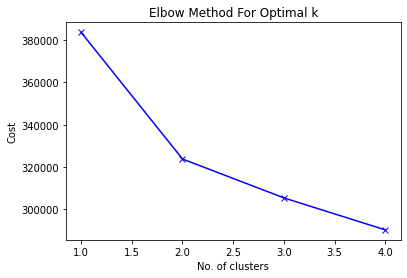

In [55]:
# Elbow curve to find optimal K -> silhoutte plot / elbow curve
cost = []
K = range(1,5)
for num_clusters in K:
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(data)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

#### Initializing clusters
Initialization method according to Cao, Liang, & Bai, 2009. To be coded.

#### Model
Source: https://www.analyticsvidhya.com/blog/2021/06/kmodes-clustering-algorithm-for-categorical-data/

In [56]:
# Building the model with n clusters
# Change value for n_clusters in case you want to run for other amount of clusters
kmode = KModes(n_clusters=3, init = "random", n_init = 5, verbose=1)
clusters = kmode.fit_predict(data)
clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 20280, cost: 305826.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 18493, cost: 320120.0
Run 2, iteration: 2/100, moves: 1130, cost: 320120.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 22572, cost: 319960.0
Run 3, iteration: 2/100, moves: 32636, cost: 307231.0
Run 3, iteration: 3/100, moves: 2910, cost: 306981.0
Run 3, iteration: 4/100, moves: 25, cost: 306981.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 20835, cost: 318716.0
Run 4, iteration: 2/100, moves: 807, cost: 318716.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 12675, cost: 320170.0
Run 5, iteration: 2/100, moves: 17584, cost: 308148.0
Run 5, iterat

array([1, 0, 0, ..., 1, 1, 0], dtype=uint16)

Cluster info on rows

In [57]:
# Get the centroids
centroids = kmode.cluster_centroids_

# Calculate distances of data points to centroids
distances = np.zeros(len(data))
for j, point in enumerate(data.values):
    min_distance = float('inf')
    for centroid in centroids:
        distance = np.sum(point != centroid)
        if distance < min_distance:
            min_distance = distance
    distances[j] = min_distance

# Insert the predicted cluster values and distances in our original dataset
data.insert(0, "Cluster", clusters, True)
data.insert(1, "Distance to Closest Centroid", distances, True)

data.head()

,Cluster,Distance to Closest Centroid,Artnr First 3,Brand,Genart description,PMVA,Axle,Truck,Tractor,PC,Bus
0,1,8.0,914,WABCO,"Brake Valve, trailer",0100,0,0,0,0,0
1,0,7.0,188,SACHS,Clutch Pressure Plate,0100,0,0,1,0,0
2,0,7.0,271,LEMFÖRDER,"Tensioner Pulley, timing belt",0100,0,0,0,1,0
3,2,7.0,BHT,TRW,Brake Caliper,T001,0,0,0,1,0
4,0,7.0,997,SACHS,Suspension Spring,0100,0,0,0,1,0


Find Type 2 Outliers according to ROAD algorithm

\* only correct initialization method is missing

In [58]:
Type_2_outliers = data.sort_values(by='Distance to Closest Centroid', ascending=False)
Type_2_outliers.head()

,Cluster,Distance to Closest Centroid,Artnr First 3,Brand,Genart description,PMVA,Axle,Truck,Tractor,PC,Bus
50000,1,9.0,SG1,null,Gas Spring,9999,0,0,0,0,0
69022,0,9.0,842,null,"Gas Spring, boot/cargo area",null,0,1,0,1,1
69025,0,9.0,25-,BOGE,Suspension Spring,1200,0,0,0,1,0
69030,1,9.0,LKC,LUCAS,Clutch Kit,null,0,0,0,0,0
69033,0,9.0,LRA,LUCAS,Alternator,null,0,0,0,1,0


Cluster 0 - Type 2 Outliers

In [59]:
Type_2_outliers[Type_2_outliers['Cluster'] == 0].head()

,Cluster,Distance to Closest Centroid,Artnr First 3,Brand,Genart description,PMVA,Axle,Truck,Tractor,PC,Bus
69022,0,9.0,842,null,"Gas Spring, boot/cargo area",null,0,1,0,1,1
69025,0,9.0,25-,BOGE,Suspension Spring,1200,0,0,0,1,0
69033,0,9.0,LRA,LUCAS,Alternator,null,0,0,0,1,0
21707,0,9.0,LRS,LUCAS,Starter,null,0,0,0,1,0
21704,0,9.0,LGS,LUCAS,"Sensor, exhaust gas temperature",null,0,0,0,1,0
